# Import module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
import pickle
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Import data

In [2]:
df1 = pd.read_csv('./data/email_classification.csv')

In [3]:
df2 = pd.read_csv('./data/spam_ham_dataset.csv')

In [4]:
df1.head(5)

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


In [5]:
# Swap the column
df1 = df1[['label', 'email']]

In [6]:
df1.columns = ['Category','Message']

In [7]:
df2.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
df2 = df2.drop(df2.columns[[0, 3]], axis=1)

In [9]:
df2.head(5)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [10]:
df2.columns = ['Category','Message']

In [11]:
df = pd.concat([df1, df2], ignore_index=True)
df

,Category,Message
0,ham,Upgrade to our premium plan for exclusive acce...
1,ham,Happy holidays from our team! Wishing you joy ...
2,ham,We're hiring! Check out our career opportuniti...
3,spam,Your Amazon account has been locked. Click her...
4,ham,Your opinion matters! Take our survey and help...
...,...,...
5345,ham,Subject: put the 10 on the ft\r\nthe transport...
5346,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...
5347,ham,Subject: calpine daily gas nomination\r\n>\r\n...
5348,ham,Subject: industrial worksheets for august 2000...


# Preprocessing

In [12]:
# Define the preprocess function
def preprocess_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Tokenize words => cut the word
    words = nltk.word_tokenize(text)
    # POS tagging
    pos_tags = nltk.pos_tag(words)

    # Filter out less meaningful words based on their POS tags
    # Keep only nouns, verbs, adjectives, and adverbs
    meaningful_pos = {'NN', 'NNS', 
                      'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 
                      'JJ', 'JJR', 'JJS',
                      'RB', 'RBR', 'RBS'}
    filtered_words = [word for word, pos in pos_tags if pos in meaningful_pos]

    return ' '.join(filtered_words)

df['Message'] = df['Message'].apply(preprocess_text)
df

,Category,Message
0,ham,upgrade premium plan exclusive access premium ...
1,ham,happy holidays team wishing joy prosperity season
2,ham,were hiring check career opportunities join dy...
3,spam,amazon account has been locked click here veri...
4,ham,opinion matters take survey help enhance exper...
...,...,...
5345,ham,subject put ft transport volumes decreased be ...
5346,ham,subject following noms hpl t take extra mmcf d...
5347,ham,subject calpine daily gas nomination julie i m...
5348,ham,subject industrial worksheets august activity ...


In [13]:
df.shape

(5350, 2)

In [14]:
# Find unique Category
df['Category'].value_counts()

ham     3772
spam    1578
Name: Category, dtype: int64

In [15]:
# Remove rows with invalid categories
valid_categories = ['ham', 'spam']
df = df[df['Category'].isin(valid_categories)]
df.shape

(5350, 2)

In [16]:
# Encode the 'Category' column: 0 for ham, 1 for spam
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [17]:
df

,Category,Message
0,0,upgrade premium plan exclusive access premium ...
1,0,happy holidays team wishing joy prosperity season
2,0,were hiring check career opportunities join dy...
3,1,amazon account has been locked click here veri...
4,0,opinion matters take survey help enhance exper...
...,...,...
5345,0,subject put ft transport volumes decreased be ...
5346,0,subject following noms hpl t take extra mmcf d...
5347,0,subject calpine daily gas nomination julie i m...
5348,0,subject industrial worksheets august activity ...


In [18]:
# Drop duplicates row
df.drop_duplicates(inplace=True)
df

,Category,Message
0,0,upgrade premium plan exclusive access premium ...
1,0,happy holidays team wishing joy prosperity season
2,0,were hiring check career opportunities join dy...
3,1,amazon account has been locked click here veri...
4,0,opinion matters take survey help enhance exper...
...,...,...
5343,1,subject slutty milf wants meet take ilaa liqaa
5345,0,subject put ft transport volumes decreased be ...
5346,0,subject following noms hpl t take extra mmcf d...
5348,0,subject industrial worksheets august activity ...


In [19]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

# EDA

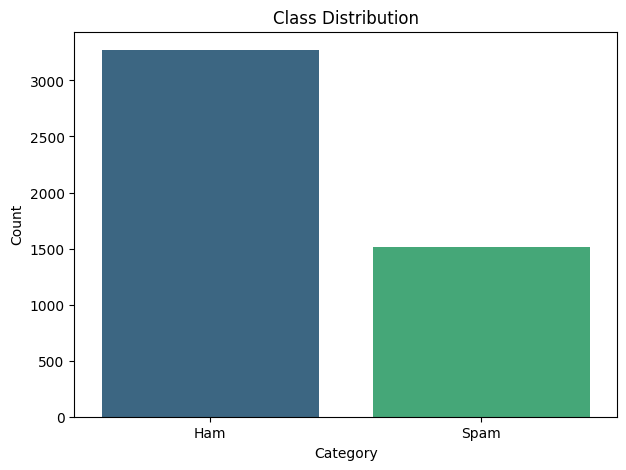

In [20]:
# Plot class distribution
plt.figure(figsize=(7,5))
sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

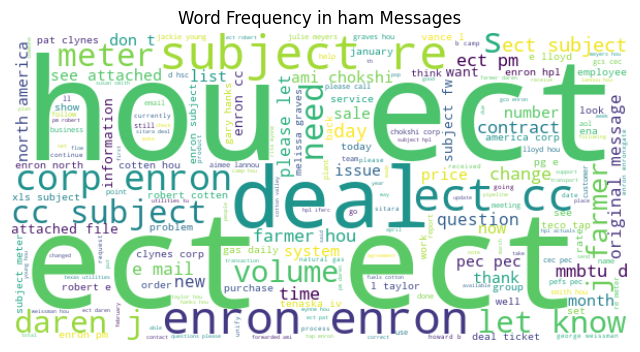

In [21]:
hamtext = ' '.join(df[df['Category'] == 0]['Message'])

# Generate a word cloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(hamtext)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency in ham Messages')
plt.show()

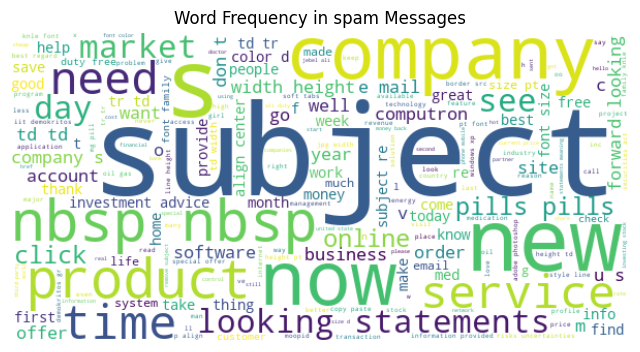

In [22]:
spamtext = ' '.join(df[df['Category'] == 1]['Message'])

# Generate a word cloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(spamtext)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency in spam Messages')
plt.show()

# Split train and test set

In [23]:
X = df['Message']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Feature engineering

In [24]:
# tfidf_vectorizer = TfidfVectorizer(max_features=5000) initializes the vectorizer with a maximum of 5,000 features. 
# This means it will only consider the top 5,000 words (based on their TF-IDF scores) as features, 
# which helps in reducing dimensionality and computational cost.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test = tfidf_vectorizer.transform(X_test).toarray()

# Cross validation

<Figure size 800x600 with 0 Axes>

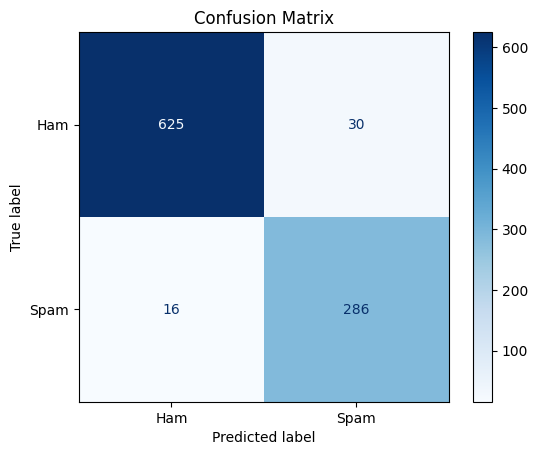

Naive Bayes Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       655
           1       0.91      0.95      0.93       302

    accuracy                           0.95       957
   macro avg       0.94      0.95      0.95       957
weighted avg       0.95      0.95      0.95       957

Naive Bayes saved as Naive Bayes_model.pkl




<Figure size 800x600 with 0 Axes>

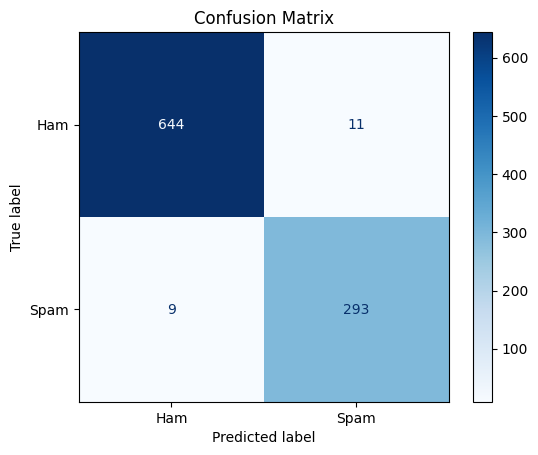

SVM Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       655
           1       0.96      0.97      0.97       302

    accuracy                           0.98       957
   macro avg       0.98      0.98      0.98       957
weighted avg       0.98      0.98      0.98       957

SVM saved as SVM_model.pkl




<Figure size 800x600 with 0 Axes>

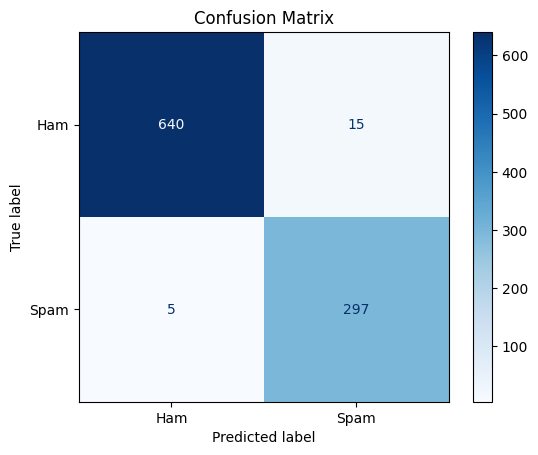

Random Forest Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       655
           1       0.95      0.98      0.97       302

    accuracy                           0.98       957
   macro avg       0.97      0.98      0.98       957
weighted avg       0.98      0.98      0.98       957

Random Forest saved as Random Forest_model.pkl




In [25]:
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results_accuracy = {}
results_precision = {}
results_f1_score = {}
results_recall = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

    results_accuracy[model_name] = accuracy
    results_precision[model_name] = precision
    results_f1_score[model_name] = f1
    results_recall[model_name] = recall
    
    # Model pickle
    model_filename = f"{model_name}_model.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"{model_name} saved as {model_filename}\n\n")


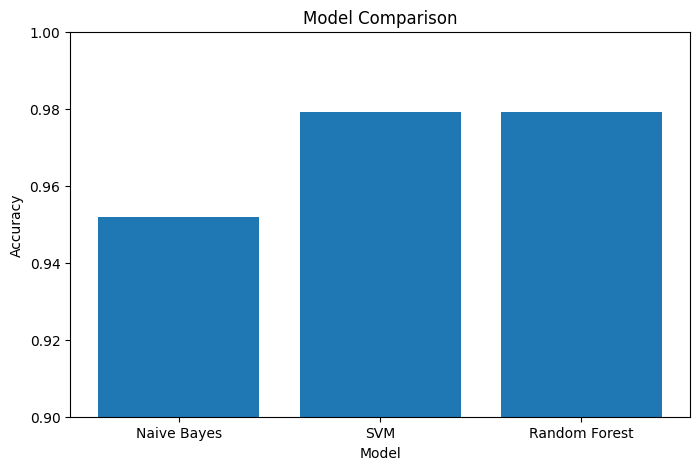

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(results_accuracy.keys(), results_accuracy.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.show()

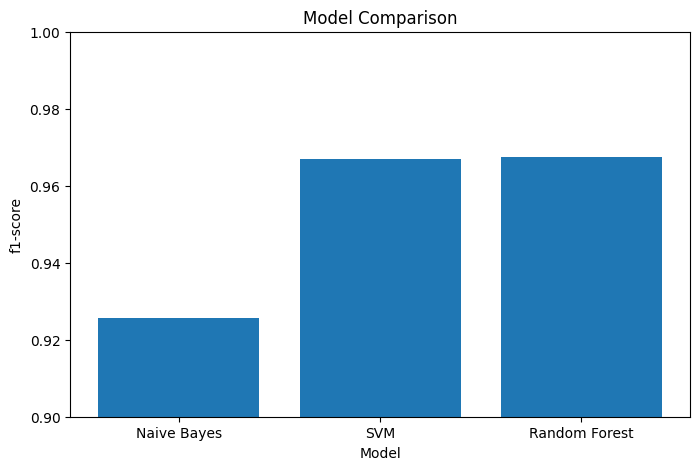

In [27]:
plt.figure(figsize=(8, 5))
plt.bar(results_f1_score.keys(), results_f1_score.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('f1-score')
plt.ylim(0.9, 1.0)
plt.show()

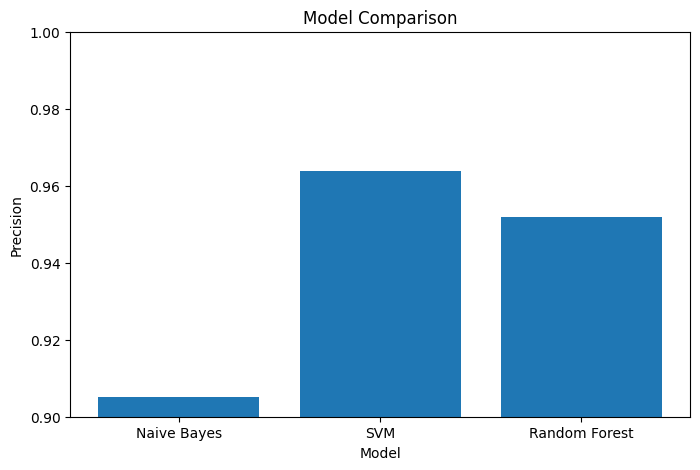

In [28]:
plt.figure(figsize=(8, 5))
plt.bar(results_precision.keys(), results_precision.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0.9, 1.0)
plt.show()

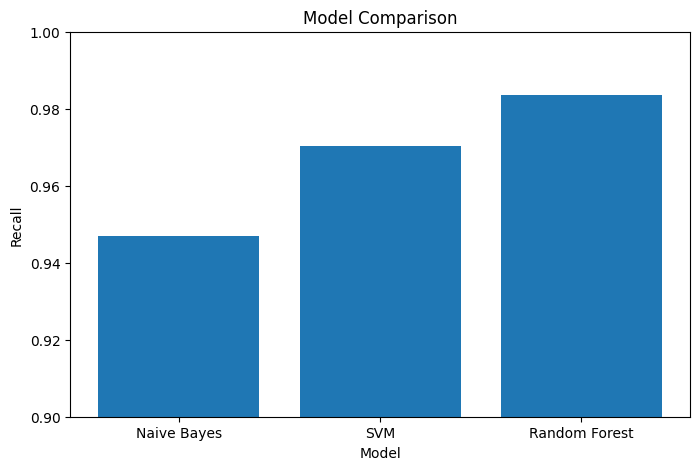

In [29]:
plt.figure(figsize=(8, 5))
plt.bar(results_recall.keys(), results_recall.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0.9, 1.0)
plt.show()